# 🗑️ Trash-Buddy Inference Pipeline

## Overview
This notebook handles the fifth step of the Trash-Buddy pipeline: **Model Inference**. After training and evaluation, we create:

- Model loading and inference functions
- Single image prediction
- Batch image prediction
- Prediction visualization
- Confidence scores and top-k predictions
- Exportable inference script

---

## 📊 Prerequisites

From previous steps, we have:
- **Trained model** saved as checkpoint (from Step 3)
- **Label classes** and encoders (from Step 2)
- **Preprocessing configuration** (image size, normalization)

---

## 🎯 Objectives
1. Load trained model and configurations
2. Create inference functions for single and batch predictions
3. Visualize predictions with confidence scores
4. Handle edge cases and errors gracefully
5. Create reusable inference utilities


In [2]:
# Import necessary libraries
import os
import json
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
from torchvision import transforms, models
import torch.nn.functional as F

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else'cpu')
print(f"Using device: {device}")

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Libraries imported successfully!")


Using device: cpu
Libraries imported successfully!


## 📁 Load Model and Configuration

Load the trained model and necessary configurations.


In [3]:
# Define paths
models_dir = Path('models')
processed_data_dir = Path('processed_data')

# Load model checkpoint
model_checkpoint_path = list(models_dir.glob('best_model_*.pth'))[0]
checkpoint = torch.load(model_checkpoint_path, map_location=device, weights_only=False)

# Get model configuration
model_config = checkpoint.get('config', {})
MODEL_NAME = model_config.get('MODEL_NAME','resnet50')
IMAGE_SIZE = model_config.get('IMAGE_SIZE', 224)
IMAGENET_MEAN = model_config.get('IMAGENET_MEAN', [0.485, 0.456, 0.406])
IMAGENET_STD = model_config.get('IMAGENET_STD', [0.229, 0.224, 0.225])

# Load label classes
label_classes = np.load(processed_data_dir /'label_classes.npy', allow_pickle=True)

# Create label encoder
label_encoder = LabelEncoder()
label_encoder.classes_ = label_classes

NUM_CLASSES = len(label_classes)

print("=" * 80)
print("MODEL LOADING")
print("=" * 80)
print(f"\n Model checkpoint loaded: {model_checkpoint_path.name}")
print(f" Model architecture: {MODEL_NAME}")
print(f" Number of classes: {NUM_CLASSES}")
print(f" Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f" Trained for {checkpoint['epoch']} epochs")
print(f" Validation accuracy: {checkpoint['val_acc']:.2f}%")
print(f"\n Label classes loaded: {len(label_classes)} classes")


MODEL LOADING

✅ Model checkpoint loaded: best_model_resnet50.pth
   Model architecture: resnet50
   Number of classes: 18
   Image size: 224x224
   Trained for 30 epochs
   Validation accuracy: 74.91%

✅ Label classes loaded: 18 classes


## 🏗️ Model Architecture Setup

Recreate the model architecture and load weights.


In [4]:
def create_model(model_name='resnet50', num_classes=18):
"""Create model architecture"""
 try:
 if model_name =='resnet50':
 weights = models.ResNet50_Weights.DEFAULT
 model = models.resnet50(weights=weights)
 model.fc = nn.Linear(model.fc.in_features, num_classes)
 elif model_name =='efficientnet_b0':
 weights = models.EfficientNet_B0_Weights.DEFAULT
 model = models.efficientnet_b0(weights=weights)
 model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
 elif model_name =='mobilenet_v2':
 weights = models.MobileNet_V2_Weights.DEFAULT
 model = models.mobilenet_v2(weights=weights)
 model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
 else:
 raise ValueError(f"Unknown model: {model_name}")
 except AttributeError:
 # Fallback for older versions
 if model_name =='resnet50':
 model = models.resnet50(pretrained=True)
 model.fc = nn.Linear(model.fc.in_features, num_classes)
 elif model_name =='efficientnet_b0':
 model = models.efficientnet_b0(pretrained=True)
 model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
 elif model_name =='mobilenet_v2':
 model = models.mobilenet_v2(pretrained=True)
 model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
 return model

# Create and load model
model = create_model(MODEL_NAME, NUM_CLASSES)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print("=" * 80)
print("MODEL SETUP")
print("=" * 80)
print(f" Model created and loaded successfully")
print(f" Model on device: {device}")
print(f" Model in eval mode: {not model.training}")


MODEL SETUP
✅ Model created and loaded successfully
   Model on device: cpu
   Model in eval mode: True


## 🔄 Preprocessing Functions

Define image preprocessing transforms for inference.


In [5]:
# Define preprocessing transforms
preprocess = transforms.Compose([
 transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
 transforms.ToTensor(),
 transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

def preprocess_image(image_path):
"""
 Preprocess a single image for inference
 
 Args:
 image_path: Path to image file or PIL Image object
 
 Returns:
 Preprocessed tensor ready for model input
"""
 if isinstance(image_path,(str, Path)):
 image = Image.open(image_path).convert('RGB')
 elif isinstance(image_path, Image.Image):
 image = image_path.convert('RGB')
 else:
 raise ValueError(f"Unsupported image type: {type(image_path)}")
 
 # Preprocess
 image_tensor = preprocess(image)
 return image_tensor.unsqueeze(0) # Add batch dimension

print(" Preprocessing functions defined!")


✅ Preprocessing functions defined!


## 🔮 Inference Functions

Create functions for making predictions.


In [6]:
def predict_single(image_path, top_k=3, return_probs=False):
"""
 Predict class for a single image
 
 Args:
 image_path: Path to image file or PIL Image
 top_k: Number of top predictions to return
 return_probs: If True, return all probabilities
 
 Returns:
 Dictionary with predictions and confidence scores
"""
 # Preprocess image
 image_tensor = preprocess_image(image_path).to(device)
 
 # Make prediction
 with torch.no_grad():
 outputs = model(image_tensor)
 probs = F.softmax(outputs, dim=1)
 top_probs, top_indices = torch.topk(probs, k=min(top_k, NUM_CLASSES), dim=1)
 
 # Convert to numpy
 top_probs = top_probs.cpu().numpy()[0]
 top_indices = top_indices.cpu().numpy()[0]
 
 # Get class names
 top_classes = [label_classes[idx] for idx in top_indices]
 
 result = {
'predicted_class': top_classes[0],
'confidence': float(top_probs[0]),
'top_k': [
 {'class': cls,'confidence': float(prob)}
 for cls, prob in zip(top_classes, top_probs)
 ]
 }
 
 if return_probs:
 all_probs = probs.cpu().numpy()[0]
 result['all_probabilities'] = {
 label_classes[i]: float(all_probs[i])
 for i in range(NUM_CLASSES)
 }
 
 return result

def predict_batch(image_paths, top_k=3, batch_size=32):
"""
 Predict classes for multiple images
 
 Args:
 image_paths: List of image paths
 top_k: Number of top predictions per image
 batch_size: Batch size for processing
 
 Returns:
 List of prediction dictionaries
"""
 results = []
 
 # Process in batches
 for i in range(0, len(image_paths), batch_size):
 batch_paths = image_paths[i:i+batch_size]
 batch_tensors = []
 
 # Preprocess batch
 for img_path in batch_paths:
 try:
 tensor = preprocess_image(img_path)
 batch_tensors.append(tensor)
 except Exception as e:
 print(f"Error loading {img_path}: {e}")
 results.append({
'image_path': str(img_path),
'error': str(e)
 })
 continue
 
 if not batch_tensors:
 continue
 
 # Stack tensors
 batch_tensor = torch.cat(batch_tensors, dim=0).to(device)
 
 # Make predictions
 with torch.no_grad():
 outputs = model(batch_tensor)
 probs = F.softmax(outputs, dim=1)
 top_probs, top_indices = torch.topk(probs, k=min(top_k, NUM_CLASSES), dim=1)
 
 # Process results
 for j, img_path in enumerate(batch_paths):
 if j < len(batch_tensors):
 top_probs_j = top_probs[j].cpu().numpy()
 top_indices_j = top_indices[j].cpu().numpy()
 top_classes_j = [label_classes[idx] for idx in top_indices_j]
 
 results.append({
'image_path': str(img_path),
'predicted_class': top_classes_j[0],
'confidence': float(top_probs_j[0]),
'top_k': [
 {'class': cls,'confidence': float(prob)}
 for cls, prob in zip(top_classes_j, top_probs_j)
 ]
 })
 
 return results

print(" Inference functions defined!")
print(" - predict_single(): Predict for one image")
print(" - predict_batch(): Predict for multiple images")


✅ Inference functions defined!
   - predict_single(): Predict for one image
   - predict_batch(): Predict for multiple images


SINGLE IMAGE PREDICTION

📸 Image: Data/test-image-1.jpg

🎯 Prediction:
   Class: batteries
   Confidence: 0.9993 (99.93%)

📊 Top 5 Predictions:
   1. batteries                      0.9993 (99.93%)
   2. cans_all_type                  0.0006 (0.06%)
   3. paints                         0.0001 (0.01%)
   4. e-waste                        0.0000 (0.00%)
   5. food_scraps                    0.0000 (0.00%)


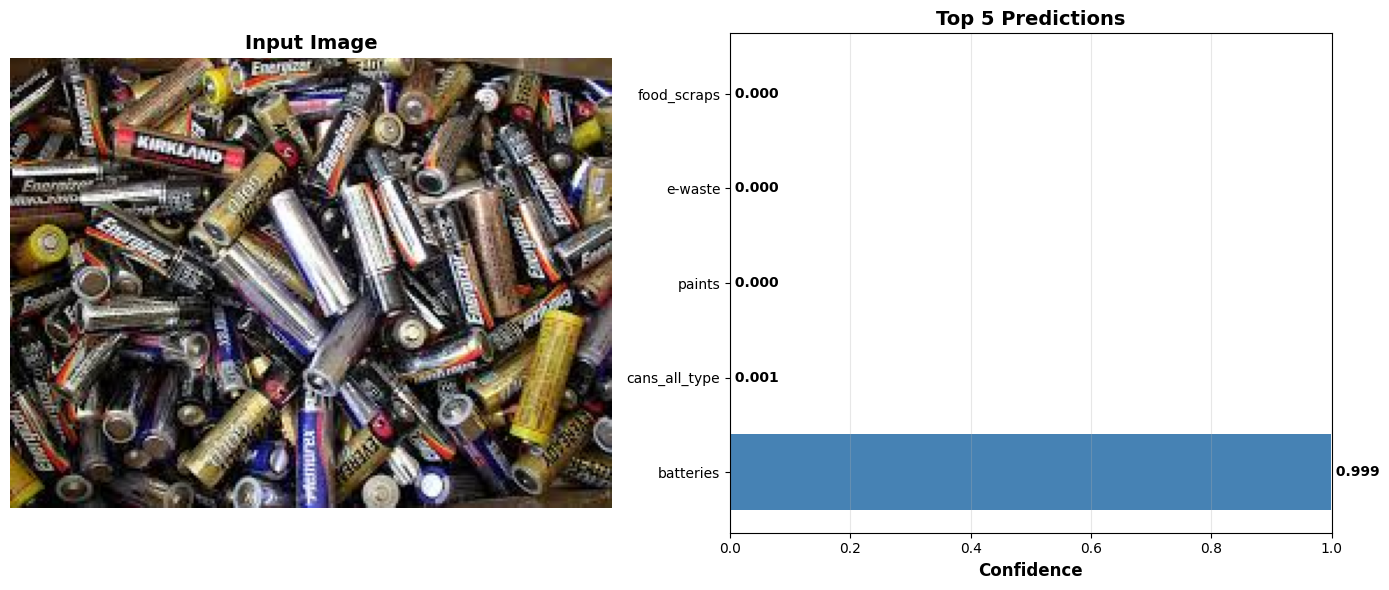

In [10]:
# Example: Predict on a single image
# Replace with path to your test image
test_image_path ="Data/test-image-1.jpg" # Set this to a test image path

if test_image_path and Path(test_image_path).exists():
 # Make prediction
 result = predict_single(test_image_path, top_k=5, return_probs=True)
 
 # Display results
 print("=" * 80)
 print("SINGLE IMAGE PREDICTION")
 print("=" * 80)
 print(f"\n Image: {test_image_path}")
 print(f"\n Prediction:")
 print(f" Class: {result['predicted_class']}")
 print(f" Confidence: {result['confidence']:.4f}({result['confidence']*100:.2f}%)")
 
 print(f"\n Top 5 Predictions:")
 for i, pred in enumerate(result['top_k'], 1):
 print(f" {i}. {pred['class']:<30s} {pred['confidence']:.4f}({pred['confidence']*100:.2f}%)")
 
 # Visualize
 fig, axes = plt.subplots(1, 2, figsize=(14, 6))
 
 # Original image
 img = Image.open(test_image_path).convert('RGB')
 axes[0].imshow(img)
 axes[0].axis('off')
 axes[0].set_title(f'Input Image', fontsize=14, fontweight='bold')
 
 # Top predictions bar chart
 top_classes = [p['class'] for p in result['top_k']]
 top_confs = [p['confidence'] for p in result['top_k']]
 
 axes[1].barh(range(len(top_classes)), top_confs, color='steelblue')
 axes[1].set_yticks(range(len(top_classes)))
 axes[1].set_yticklabels(top_classes)
 axes[1].set_xlabel('Confidence', fontsize=12, fontweight='bold')
 axes[1].set_title('Top 5 Predictions', fontsize=14, fontweight='bold')
 axes[1].set_xlim(0, 1)
 axes[1].grid(axis='x', alpha=0.3)
 
 # Add confidence labels
 for i, conf in enumerate(top_confs):
 axes[1].text(conf, i, f' {conf:.3f}', va='center', fontweight='bold')
 
 plt.tight_layout()
 plt.show()
 
else:
 print(" No test image provided or image not found")
 print(" Set'test_image_path' variable to test inference on an image")
 print(" Example: test_image_path ='path/to/your/image.jpg'")


In [12]:
# Example: Predict on multiple images
# Replace with list of image paths
test_image_paths = [
"Data/test-image-1.jpg",
"Data/test-image-2.jpg",
"Data/test-image-3.jpg"
] # Set this to a list of test image paths

if test_image_paths and all(Path(p).exists() for p in test_image_paths):
 # Make predictions
 results = predict_batch(test_image_paths, top_k=3, batch_size=32)
 
 # Display results
 print("=" * 80)
 print("BATCH PREDICTION RESULTS")
 print("=" * 80)
 
 for i, result in enumerate(results, 1):
 if'error' in result:
 print(f"\n Image {i}: {result['image_path']}")
 print(f" Error: {result['error']}")
 else:
 print(f"\n Image {i}: {Path(result['image_path']).name}")
 print(f" Predicted: {result['predicted_class']}({result['confidence']*100:.2f}%)")
 top3_str =','.join([f"{p['class']}({p['confidence']*100:.1f}%)" for p in result['top_k']])
 print(f" Top 3: {top3_str}")
 
 # Summary statistics
 successful = [r for r in results if'error' not in r]
 if successful:
 avg_confidence = np.mean([r['confidence'] for r in successful])
 print(f"\n Summary:")
 print(f" Total images: {len(results)}")
 print(f" Successful: {len(successful)}")
 print(f" Errors: {len(results) - len(successful)}")
 print(f" Average confidence: {avg_confidence:.4f}({avg_confidence*100:.2f}%)")
 
 # Class distribution
 predicted_classes = [r['predicted_class'] for r in successful]
 class_counts = pd.Series(predicted_classes).value_counts()
 print(f"\n Predicted Class Distribution:")
 for cls, count in class_counts.items():
 print(f" {cls}: {count}({count/len(successful)*100:.1f}%)")
 
else:
 print(" No test images provided or images not found")
 print(" Set'test_image_paths' variable to a list of image paths")
 print(" Example: test_image_paths = ['path/to/image1.jpg','path/to/image2.jpg']")


BATCH PREDICTION RESULTS

📸 Image 1: test-image-1.jpg
   Predicted: batteries (99.93%)
   Top 3: batteries (99.9%), cans_all_type (0.1%), paints (0.0%)

📸 Image 2: test-image-2.jpg
   Predicted: e-waste (99.92%)
   Top 3: e-waste (99.9%), cans_all_type (0.1%), coffee_tea_bags (0.0%)

📸 Image 3: test-image-3.jpg
   Predicted: food_scraps (99.97%)
   Top 3: food_scraps (100.0%), kitchen_waste (0.0%), coffee_tea_bags (0.0%)

📊 Summary:
   Total images: 3
   Successful: 3
   Errors: 0
   Average confidence: 0.9994 (99.94%)

📊 Predicted Class Distribution:
   batteries: 1 (33.3%)
   e-waste: 1 (33.3%)
   food_scraps: 1 (33.3%)


## 🎨 Visualization Functions

Create functions to visualize predictions.


In [13]:
def visualize_prediction(image_path, result, save_path=None):
"""
 Visualize prediction result for a single image
 
 Args:
 image_path: Path to the image
 result: Prediction result dictionary
 save_path: Optional path to save the visualization
"""
 fig, axes = plt.subplots(1, 2, figsize=(16, 6))
 
 # Load and display image
 img = Image.open(image_path).convert('RGB')
 axes[0].imshow(img)
 axes[0].axis('off')
 
 # Add prediction text on image
 pred_text = f"Predicted: {result['predicted_class']}\n"
 pred_text += f"Confidence: {result['confidence']*100:.2f}%"
 axes[0].text(0.02, 0.98, pred_text, 
 transform=axes[0].transAxes,
 fontsize=14, fontweight='bold',
 verticalalignment='top',
 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
 axes[0].set_title('Input Image', fontsize=14, fontweight='bold', pad=10)
 
 # Top predictions bar chart
 top_classes = [p['class'] for p in result['top_k']]
 top_confs = [p['confidence'] for p in result['top_k']]
 
 colors = ['green' if i == 0 else'steelblue' for i in range(len(top_classes))]
 bars = axes[1].barh(range(len(top_classes)), top_confs, color=colors)
 axes[1].set_yticks(range(len(top_classes)))
 axes[1].set_yticklabels(top_classes, fontsize=11)
 axes[1].set_xlabel('Confidence Score', fontsize=12, fontweight='bold')
 axes[1].set_title('Top Predictions', fontsize=14, fontweight='bold', pad=10)
 axes[1].set_xlim(0, 1)
 axes[1].grid(axis='x', alpha=0.3)
 
 # Add confidence labels
 for i,(bar, conf) in enumerate(zip(bars, top_confs)):
 axes[1].text(conf, i, f' {conf:.3f}({conf*100:.1f}%)', 
 va='center', fontweight='bold', fontsize=10)
 
 plt.tight_layout()
 
 if save_path:
 plt.savefig(save_path, dpi=150, bbox_inches='tight')
 print(f" Visualization saved to: {save_path}")
 
 plt.show()

def visualize_batch_predictions(image_paths, results, max_images=12, save_path=None):
"""
 Visualize predictions for multiple images in a grid
 
 Args:
 image_paths: List of image paths
 results: List of prediction results
 max_images: Maximum number of images to display
 save_path: Optional path to save the visualization
"""
 # Filter successful predictions
 valid_results = [(path, res) for path, res in zip(image_paths, results) 
 if'error' not in res and Path(path).exists()]
 
 num_images = min(len(valid_results), max_images)
 if num_images == 0:
 print(" No valid images to display")
 return
 
 # Calculate grid size
 cols = 4
 rows =(num_images + cols - 1) // cols
 
 fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
 fig.suptitle('Batch Predictions', fontsize=16, fontweight='bold', y=0.995)
 
 if rows == 1:
 axes = axes.reshape(1, -1)
 axes = axes.flatten()
 
 for idx in range(num_images):
 img_path, result = valid_results[idx]
 
 # Load and display image
 img = Image.open(img_path).convert('RGB')
 axes[idx].imshow(img)
 axes[idx].axis('off')
 
 # Add prediction text
 pred_text = f"{result['predicted_class']}\n"
 pred_text += f"{result['confidence']*100:.1f}%"
 axes[idx].set_title(pred_text, fontsize=10, fontweight='bold', pad=5)
 
 # Hide unused subplots
 for idx in range(num_images, len(axes)):
 axes[idx].axis('off')
 
 plt.tight_layout()
 
 if save_path:
 plt.savefig(save_path, dpi=150, bbox_inches='tight')
 print(f" Visualization saved to: {save_path}")
 
 plt.show()

print(" Visualization functions defined!")
print(" - visualize_prediction(): Visualize single image prediction")
print(" - visualize_batch_predictions(): Visualize multiple predictions in grid")


✅ Visualization functions defined!
   - visualize_prediction(): Visualize single image prediction
   - visualize_batch_predictions(): Visualize multiple predictions in grid


## 📝 Exportable Inference Script

Create a standalone inference script that can be used outside the notebook.


In [15]:
# Create inference script
inference_script ='''"""
Trash-Buddy Inference Script
Standalone script for making predictions on waste images
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image
import numpy as np
from pathlib import Path
import json
import argparse

class WasteClassifier:
"""Waste classification model wrapper"""
 
 def __init__(self, model_path, label_classes_path, device='auto'):
"""
 Initialize the classifier
 
 Args:
 model_path: Path to model checkpoint(.pth file)
 label_classes_path: Path to label classes(.npy file)
 device: Device to use('auto','cuda', or'cpu')
"""
 # Set device
 if device =='auto':
 self.device = torch.device('cuda' if torch.cuda.is_available() else'cpu')
 else:
 self.device = torch.device(device)
 
 # Load label classes
 self.label_classes = np.load(label_classes_path, allow_pickle=True)
 
 # Load model checkpoint
 checkpoint = torch.load(model_path, map_location=self.device, weights_only=False)
 model_config = checkpoint.get('config', {})
 
 self.model_name = model_config.get('MODEL_NAME','resnet50')
 self.image_size = model_config.get('IMAGE_SIZE', 224)
 self.imagenet_mean = model_config.get('IMAGENET_MEAN', [0.485, 0.456, 0.406])
 self.imagenet_std = model_config.get('IMAGENET_STD', [0.229, 0.224, 0.225])
 
 # Create model
 self.model = self._create_model(self.model_name, len(self.label_classes))
 self.model.load_state_dict(checkpoint['model_state_dict'])
 self.model = self.model.to(self.device)
 self.model.eval()
 
 # Preprocessing
 self.preprocess = transforms.Compose([
 transforms.Resize((self.image_size, self.image_size)),
 transforms.ToTensor(),
 transforms.Normalize(mean=self.imagenet_mean, std=self.imagenet_std)
 ])
 
 def _create_model(self, model_name, num_classes):
"""Create model architecture"""
 try:
 if model_name =='resnet50':
 weights = models.ResNet50_Weights.DEFAULT
 model = models.resnet50(weights=weights)
 model.fc = nn.Linear(model.fc.in_features, num_classes)
 elif model_name =='efficientnet_b0':
 weights = models.EfficientNet_B0_Weights.DEFAULT
 model = models.efficientnet_b0(weights=weights)
 model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
 elif model_name =='mobilenet_v2':
 weights = models.MobileNet_V2_Weights.DEFAULT
 model = models.mobilenet_v2(weights=weights)
 model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
 else:
 raise ValueError(f"Unknown model: {model_name}")
 except AttributeError:
 # Fallback for older versions
 if model_name =='resnet50':
 model = models.resnet50(pretrained=True)
 model.fc = nn.Linear(model.fc.in_features, num_classes)
 elif model_name =='efficientnet_b0':
 model = models.efficientnet_b0(pretrained=True)
 model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
 elif model_name =='mobilenet_v2':
 model = models.mobilenet_v2(pretrained=True)
 model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
 return model
 
 def predict(self, image_path, top_k=3):
"""
 Predict class for an image
 
 Args:
 image_path: Path to image file
 top_k: Number of top predictions to return
 
 Returns:
 Dictionary with predictions
"""
 # Load and preprocess image
 image = Image.open(image_path).convert('RGB')
 image_tensor = self.preprocess(image).unsqueeze(0).to(self.device)
 
 # Make prediction
 with torch.no_grad():
 outputs = self.model(image_tensor)
 probs = F.softmax(outputs, dim=1)
 top_probs, top_indices = torch.topk(probs, k=min(top_k, len(self.label_classes)), dim=1)
 
 # Format results
 top_probs = top_probs.cpu().numpy()[0]
 top_indices = top_indices.cpu().numpy()[0]
 top_classes = [self.label_classes[idx] for idx in top_indices]
 
 return {
'predicted_class': top_classes[0],
'confidence': float(top_probs[0]),
'top_k': [
 {'class': cls,'confidence': float(prob)}
 for cls, prob in zip(top_classes, top_probs)
 ]
 }


def main():
 parser = argparse.ArgumentParser(description='Trash-Buddy Inference')
 parser.add_argument('image', type=str, help='Path to image file')
 parser.add_argument('--model', type=str, default='models/best_model_resnet50.pth',
 help='Path to model checkpoint')
 parser.add_argument('--labels', type=str, default='processed_data/label_classes.npy',
 help='Path to label classes file')
 parser.add_argument('--top-k', type=int, default=3, help='Number of top predictions')
 parser.add_argument('--output', type=str, help='Output JSON file path')
 
 args = parser.parse_args()
 
 # Initialize classifier
 print(f"Loading model from {args.model}...")
 classifier = WasteClassifier(args.model, args.labels)
 print(f" Model loaded on {classifier.device}")
 
 # Make prediction
 print(f"\\nPredicting on {args.image}...")
 result = classifier.predict(args.image, top_k=args.top_k)
 
 # Display results
 print("\\n" +"="*60)
 print("PREDICTION RESULTS")
 print("="*60)
 print(f"\\nPredicted Class: {result['predicted_class']}")
 print(f"Confidence: {result['confidence']*100:.2f}%")
 print(f"\\nTop {args.top_k} Predictions:")
 for i, pred in enumerate(result['top_k'], 1):
 print(f" {i}. {pred['class']:<30s} {pred['confidence']*100:.2f}%")
 
 # Save to file if requested
 if args.output:
 with open(args.output,'w') as f:
 json.dump(result, f, indent=2)
 print(f"\\n Results saved to {args.output}")


if __name__ =='__main__':
 main()
'''

# Save the script
script_path = Path('inference.py')
with open(script_path,'w', encoding='utf-8') as f:
 f.write(inference_script)

print("=" * 80)
print("INFERENCE SCRIPT CREATED")
print("=" * 80)
print(f" Script saved to: {script_path}")
print(f"\n📝 Usage:")
print(f" python inference.py <image_path>")
print(f" python inference.py <image_path> --top-k 5")
print(f" python inference.py <image_path> --output results.json")
print(f"\n Example:")
print(f" python inference.py test_image.jpg --top-k 5 --output prediction.json")


INFERENCE SCRIPT CREATED
✅ Script saved to: inference.py

📝 Usage:
   python inference.py <image_path>
   python inference.py <image_path> --top-k 5
   python inference.py <image_path> --output results.json

📋 Example:
   python inference.py test_image.jpg --top-k 5 --output prediction.json
